<a href="https://colab.research.google.com/github/ganeshramb/GAN-MNIST/blob/main/Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [35]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# optimizers

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# training variables
epochs = 20

# Load MNIST Dataset

In [36]:
from torchvision import datasets, transforms as T

In [37]:
train_augs = T.Compose([T.RandomRotation((-20,+20)),
                        T.ToTensor()
                        ])

In [38]:
trainset = datasets.MNIST('MNIST/',download=True,train=True, transform = train_augs)

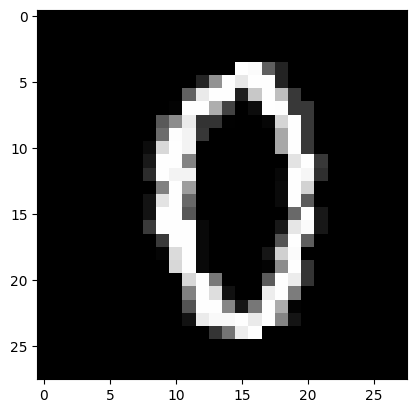

In [39]:
image,label = trainset[1000]
plt. imshow(image.squeeze (), cmap = 'gray')


# Load Dataset Into Batches

In [40]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [41]:
trainloader = DataLoader (trainset, batch_size = batch_size, shuffle = True)

In [42]:
print(len(trainloader))

469


In [43]:
dataiter=iter(trainloader)
images,_ =next(dataiter)
print (images.shape)

torch.Size([128, 1, 28, 28])


In [44]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

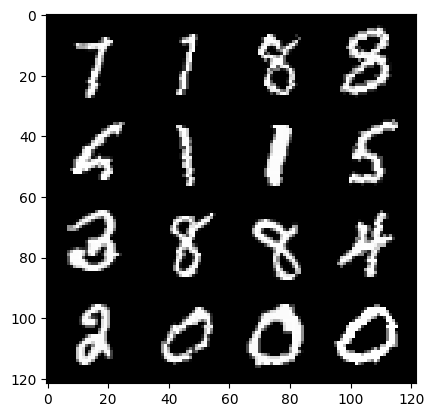

In [45]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [46]:
#In case if torch summary is not installed

!pip install torchsummary

In [47]:
from torch import nn
from torchsummary import summary

In [53]:
def get_desc_block(in_channels, out_channels, kernal_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernal_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [58]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = get_desc_block(1,16,(3,3),2)
    self.block_2 = get_desc_block(16,32,(5,5),2)
    self.block_3 = get_desc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [59]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [60]:
def get_gen_block(in_channels, out_channels,kernel_size,stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [61]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim

    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)

    self.block_4 = get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):
    x = r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4


In [62]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size= (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [63]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [64]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [68]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

In [69]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1,beta_2))


# Training Loop

In [71]:
for i in range(epochs):
  total_d_loss = 0
  total_g_loss = 0
  for real_img,_ in  tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size,noise_dim, device = device)

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss+D_real_loss)/2
    total_d_loss+=D_loss.item()

    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()

    noise = torch.randn(batch_size,noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss+=G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("epoch : {} | D_loss: {} | G_loss: {}".format(i+1,avg_d_loss,avg_g_loss))

  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 1 | D_loss: 0.6850321386922905 | G_loss: 0.7009750598275077


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 2 | D_loss: 0.6755063003822684 | G_loss: 0.7143560387432448


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 3 | D_loss: 0.629217766241224 | G_loss: 0.7679726940228232


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 4 | D_loss: 0.5883135676129795 | G_loss: 0.8275518388127976


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 5 | D_loss: 0.550934053433221 | G_loss: 0.8916794704730069


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 6 | D_loss: 0.5450695554839015 | G_loss: 0.9286078220999825


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 7 | D_loss: 0.5505607206938363 | G_loss: 0.9367585208878588


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 8 | D_loss: 0.5635517220507299 | G_loss: 0.9383751123444612


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 9 | D_loss: 0.573317721073053 | G_loss: 0.9288989813851395


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 10 | D_loss: 0.5850682583953272 | G_loss: 0.9196745528341103


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 11 | D_loss: 0.5957958580080126 | G_loss: 0.9096610570258932


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 12 | D_loss: 0.6031411532908361 | G_loss: 0.8978864780621234


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 13 | D_loss: 0.6118781611100951 | G_loss: 0.888258896275624


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 14 | D_loss: 0.6162689624310557 | G_loss: 0.8762736795807698


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 15 | D_loss: 0.6204527953286161 | G_loss: 0.8678356353153807


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 16 | D_loss: 0.6233919326430445 | G_loss: 0.8662740327656142


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 17 | D_loss: 0.6282164681949087 | G_loss: 0.8591054709735455


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 18 | D_loss: 0.6295422709572798 | G_loss: 0.8562583329835172


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 19 | D_loss: 0.6304744935747403 | G_loss: 0.8520923012863598


  0%|          | 0/469 [00:00<?, ?it/s]

epoch : 20 | D_loss: 0.6319790894288753 | G_loss: 0.8478293570119944


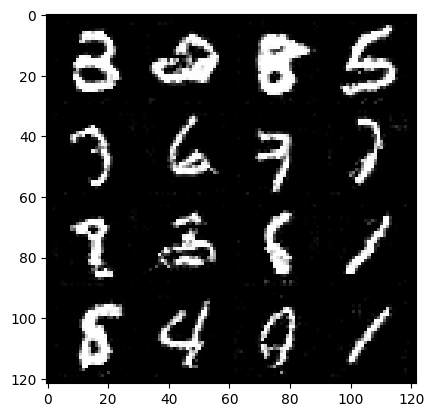

In [72]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)